<a href="https://colab.research.google.com/github/clarentcelsia/PyML/blob/master/nlp/BinaryNLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Subword


Plain_text: Default
Subwords: pretokenized dataset

In [ ]:
import tensorflow_datasets as tfds

# Download the plain_text default config
imdb_plaintext, info_plaintext = tfds.load('imdb_reviews', with_info=True, as_supervised=True)
print("imdb_plaintext : ", imdb_plaintext)
print("info_plaintext : ", info_plaintext)

# Download the subword encode pretokenized dataset
imdb_subwords, info_subwords = tfds.load('imdb_reviews/subwords8k', with_info=True, as_supervised=True)
print("imdb_subwords : ", imdb_subwords)
print("info_subwords : ", info_subwords)

In [ ]:
print(type(info_plaintext))

<class 'tensorflow_datasets.core.dataset_info.DatasetInfo'>


#### Compare 2 Datasets

For the subwords, dataset is already tokenized so the dtype will be integers.

In [ ]:
# Print desc of features
print(info_plaintext.features)
print(info_subwords.features)

FeaturesDict({
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    'text': Text(shape=(), dtype=tf.string),
})
FeaturesDict({
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    'text': Text(shape=(None,), dtype=tf.int64, encoder=<SubwordTextEncoder vocab_size=8185>),
})


In [ ]:
# Take 2 training exs and print the text feature
for example in imdb_plaintext['train'].take(2):
  print(example[0].numpy())

for example in imdb_subwords['train'].take(2):
  print(example[0].numpy())

In [ ]:
# Get the encoded text of subword
tokenizer_subwords = info_subwords.features['text'].encoder

for example in imdb_subwords['train'].take(2):
  print(tokenizer_subwords.decode(example[0]))

### Subword Text Encoding
Previously, the number of tokens in the sequence is the same as the number of words in the text. The following cells shows a review of this process.

In [ ]:
# Get the train set
train_data = imdb_plaintext['train']

# Initialize sentences list
training_sentences = []

# Loop over all training examples and save to the list
for s,_ in train_data:
  training_sentences.append(s.numpy().decode('utf8'))

training_sentences

## Build Tokenizer

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

vocab_size = 10000
oov_tok = '<OOV>'

# Initialize the tokenizer class
tokenizer_plaintext = Tokenizer(num_words = 10000, oov_token=oov_tok)

# Generate the word index dictionary for the training sentences
tokenizer_plaintext.fit_on_texts(training_sentences)

# Generate the training sequences
# Encode training text
sequences = tokenizer_plaintext.texts_to_sequences(training_sentences)



The cell above uses a vocab_size of 10000 but you'll find that it's easy to find oov tokens when decoding using the lookup dict it created.

In [ ]:
# Check the real sentence of the encoded text
# Decode the 1st seq using tokenizer class
tokenizer_plaintext.sequences_to_texts(sequences[0:1])

For binary classifier, this might not have a big impact but you may have the other apps tht will benefits from avoiding oov tokens when training model (e.g text generation). If you want the tokenizer above not to have OOV, the the vocab_size will increase to more than 88k.
This can slow down training and bloat the model size. The encoder also won't be robust when used on other datasets which may contain new words, thus resulting in OOVs again.

In [ ]:
# Total number of words in the word index dict
len(tokenizer_plaintext.word_index)

88583

Subword text encoding gets around this problem by using parts of the word to compose whole words. this makes it more flexible when it encounters uncommon words. SEE HOW THIS SUBWORDS LOOK LIKE FOR THIS PARTICULAR ENCODER:

In [ ]:
print(tokenizer_subwords.subwords)

In [ ]:
# Encode the first  plaintext sentence using the subword text encoder
tokenized_string = tokenizer_subwords.encode(training_sentences[0])
print(tokenized_string)

# Decode the sequence
original_string = tokenizer_subwords.decode(tokenized_string)

# Print the result
print(original_string) # >>> this = 62, so on..

In [ ]:
# Using Plain Text Tokenizer
# Define sample sentece
sample_str = 'Tensorflow, from basics to mastery'
tokenized_str = tokenizer_plaintext.texts_to_sequences([sample_str])
print("Plain text tokenizer : ", tokenized_str)
original_str = tokenizer_plaintext.sequences_to_texts(tokenized_str)
print(original_str)

# Using Subword Encoding
# Encode using the subword text encoder
tokenized_str = tokenizer_subwords.encode(sample_str)
print("Subword encoding : ", tokenized_str)
# Decode and print the results
original_str = tokenizer_subwords.decode(tokenized_str)
print(original_str)

Plain text tokenizer :  [[1, 37, 1, 6, 1]]
['<OOV> from <OOV> to <OOV>']
Subword encoding :  [6307, 2327, 2934, 2, 48, 4249, 4429, 7, 2652, 8050]
Tensorflow, from basics to mastery


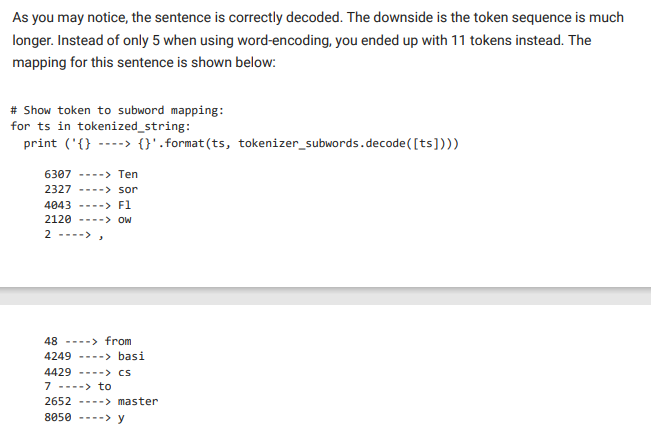

## Train Model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          523840    
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 6)                 390       
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 524,237
Trainable params: 524,237
Non-trainable params: 0
_________________________________________________________________


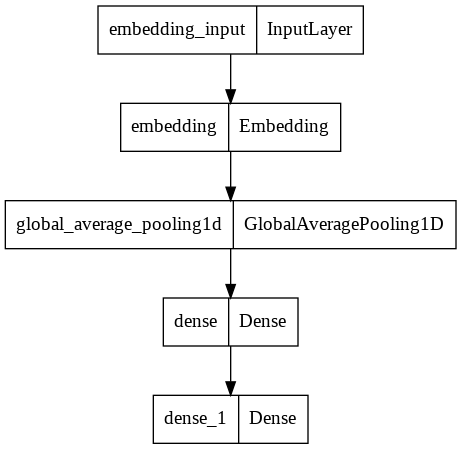

In [ ]:
import tensorflow as tf

#Training Model
BUFF_SIZE = 10000
BATCH_SIZE = 64

train_data, test_data = imdb_subwords['train'], imdb_subwords['test']

# Shuffle training data
train_dataset =train_data.shuffle(BUFF_SIZE)

train_dataset = train_data.padded_batch(BATCH_SIZE)
test_dataset = test_data.padded_batch(BATCH_SIZE)

# Build model
embedding_dim = 64 # Dimensionality of the embedding

model = tf.keras.Sequential([
  tf.keras.layers.Embedding(tokenizer_subwords.vocab_size, embedding_dim),
  tf.keras.layers.GlobalAveragePooling1D(),
  tf.keras.layers.Dense(6, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()
tf.keras.utils.plot_model(model)

**padded_batch** : create batches and pad the arrays into a uniform size for training.

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

In [ ]:
# Fit model
hist = model.fit(train_dataset, epochs=10, validation_data=test_dataset)

Epoch 1/10
391/391 [==============================] - 18s 44ms/step - loss: 0.6667 - accuracy: 0.6330 - val_loss: 0.6053 - val_accuracy: 0.7076
Epoch 2/10
391/391 [==============================] - 21s 54ms/step - loss: 0.4944 - accuracy: 0.8106 - val_loss: 0.4241 - val_accuracy: 0.8438
Epoch 3/10
391/391 [==============================] - 17s 44ms/step - loss: 0.3519 - accuracy: 0.8765 - val_loss: 0.3499 - val_accuracy: 0.8658
Epoch 4/10
391/391 [==============================] - 17s 43ms/step - loss: 0.2866 - accuracy: 0.8969 - val_loss: 0.3228 - val_accuracy: 0.8726
Epoch 5/10
391/391 [==============================] - 17s 43ms/step - loss: 0.2498 - accuracy: 0.9101 - val_loss: 0.3127 - val_accuracy: 0.8740
Epoch 6/10
391/391 [==============================] - 17s 43ms/step - loss: 0.2245 - accuracy: 0.9187 - val_loss: 0.3099 - val_accuracy: 0.8757
Epoch 7/10
391/391 [==============================] - 17s 44ms/step - loss: 0.2050 - accuracy: 0.9266 - val_loss: 0.3121 - val_accuracy:

### Visualize training set

In [ ]:
import matplotlib.pyplot as plt

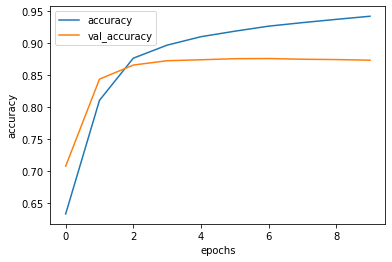

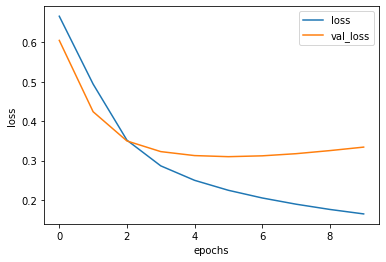

In [ ]:
def plot_graphs(model, string):
  plt.plot(model.history[string])
  plt.plot(model.history['val_'+string])
  plt.xlabel('epochs')
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(hist, 'accuracy')
plot_graphs(hist, 'loss')